In [1]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '0'

import seaborn as sns
from sklearn.metrics import confusion_matrix
from survkit.train import Trainer
from survkit.utils import get_colors
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
import numpy as np
import matplotlib.pyplot as plt

/home/iron-man/Documents/survkit/.venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
import utils
%load_ext autoreload
%autoreload 2
# change to parent directory
%cd ..

/home/iron-man/Documents/survkit


/home/iron-man/Documents/survkit/.venv/lib/python3.10/site-packages/IPython/core/magics/osm.py:417: UserWarning: This is now an optional IPython functionality, setting dhist requires you to install the `pickleshare` library.
  self.shell.db['dhist'] = compress_dhist(dhist)[-100:]


In [3]:
colors = get_colors()

# set style for plots
plt.rcParams.update({
    "font.size": 7,
    "axes.linewidth": 0.6,
    "xtick.major.width": 0.6,
    "ytick.major.width": 0.6,
    "xtick.major.size": 2,
    "ytick.major.size": 2,
    "lines.linewidth": 0.6,
    "pdf.fonttype": 42,
    "ps.fonttype": 42,
})
# use arial font
# manually add the font to the font manager, if needed
set_font = False
if set_font:
    font_dir = os.path.join(os.environ['CONDA_PREFIX'], 'fonts')
    # if envs in path, then split on that and take the first part and join with 'fonts' to get the correct font directory
    if 'envs' in font_dir:
        font_dir = os.path.join(font_dir.split('envs')[0], 'fonts')

    for f in fm.findSystemFonts(fontpaths=[font_dir]):
        fm.fontManager.addfont(f)

plt.rcParams['font.sans-serif'] = "Arial"
plt.rcParams['font.family'] = "sans-serif"

In [4]:
synthetic_data_dir = './analysis/mnist_synthetic_clustering/'
os.makedirs(synthetic_data_dir, exist_ok=True)

# Plot of the synthetic MNIST distribution and expert assignments

In [5]:
def load_model(model_dir, print_num_params=True):
    model_dir = os.path.join(model_dir, 'best')
    model_dict = utils.load_model(model_dir)
    if print_num_params:
        # count model parameters
        num_params = sum(p.numel() for p in model_dict['model'].parameters() if p.requires_grad)
        print(f'Number of parameters: {num_params}')
    return model_dict

def get_model_outputs(model_dict, loader='train'):
    model_outputs = utils.get_model_outputs(model_dict, loader=loader)
    time_bins = model_dict['time_bins'].to('cuda')
    model = model_dict['model']
    train_config = model_dict['train_config']
    trainer = Trainer(train_config, model, optimizer=None, time_bins=time_bins)
    return {**model_outputs, 'trainer': trainer}

In [6]:
model_dir = 'models/MNIST/a417c3a9_MNIST'
model_id = model_dir.split('/')[-1].split('_')[0]
model_dict = load_model(model_dir)
train_model_outputs = get_model_outputs(model_dict, loader='train')

Number of parameters: 195891


100%|██████████| 860/860 [00:06<00:00, 124.34it/s]


In [7]:
test_model_outputs = get_model_outputs(model_dict, loader='test')

100%|██████████| 157/157 [00:01<00:00, 137.12it/s]


In [8]:
group_assignments, labels = test_model_outputs['expert_scores'].argmax(dim=1).cpu(), test_model_outputs['y']

In [9]:
# create a confusion matrix
cm = confusion_matrix(group_assignments, labels, labels=[0,1,2,3,4,5,6,7,8,9])
# normalize the confusion matrix
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

/tmp/ipykernel_1693690/1348029145.py:4: RuntimeWarning: invalid value encountered in divide
  cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


In [10]:
dark_colors = [k for k in colors.keys() if 'dark' in k]

In [11]:
[colors[k] for k in dark_colors]

[(0.12156862745098039, 0.4666666666666667, 0.7058823529411765),
 (1.0, 0.4980392156862745, 0.054901960784313725),
 (0.17254901960784313, 0.6274509803921569, 0.17254901960784313),
 (0.8392156862745098, 0.15294117647058825, 0.1568627450980392),
 (0.5803921568627451, 0.403921568627451, 0.7411764705882353),
 (0.5490196078431373, 0.33725490196078434, 0.29411764705882354),
 (0.8901960784313725, 0.4666666666666667, 0.7607843137254902),
 (0.4980392156862745, 0.4980392156862745, 0.4980392156862745),
 (0.7372549019607844, 0.7411764705882353, 0.13333333333333333),
 (0.09019607843137255, 0.7450980392156863, 0.8117647058823529)]

In [12]:
def draw_sparse_routing_heatmap(
    probs,  # (R, C) row-normalized probabilities
    column_colors,  # list/array of length C, each an (r,g,b) in [0,1]
    *,
    background=(1.0, 1.0, 1.0),  # usually white
    gamma=1.0,  # <1 brightens small p; >1 darkens small p
    annotate=True,
    annotation_threshold=0.025,
    fmt="{:.2f}",
    row_labels=None,
    col_labels=None,
    title=None,
    ax=None,
):
    probs = np.asarray(probs, dtype=float)
    R, C = probs.shape
    colors = np.asarray(column_colors, dtype=float).reshape(C, 3)
    if colors.shape != (C, 3):
        raise ValueError(
            "column_colors must be length-C list/array of (r,g,b)")
    bg = np.array(background, dtype=float).reshape(1, 1, 3)

    # optional perceptual remapping of probabilities
    p = np.clip(probs, 0.0, 1.0)**gamma  # (R, C)

    # broadcast column colors over rows: (1, C, 3) -> (R, C, 3)
    base = np.broadcast_to(colors[None, :, :], (R, C, 3))

    # linear blend in RGB so that p=0 is background color, p=1 is base color
    img = (1 - p)[..., None] * bg + p[..., None] * base  # (R, C, 3)
    img = np.clip(img, 0.0, 1.0)

    # plot
    if ax is None:
        fig, ax = plt.subplots(figsize=(3, 3), dpi=300)
    # fig, ax = plt.subplots(figsize=(2.5, 2.5), dpi=150)
    ax.imshow(img, aspect="auto", interpolation="nearest")

    # grid lines on cell boundaries
    ax.set_xticks(np.arange(-0.5, C, 1), minor=True)
    ax.set_yticks(np.arange(-0.5, R, 1), minor=True)
    ax.grid(which="minor", color="black", linewidth=0.5)
    ax.tick_params(which="both", length=0)
    ax.set_xlim(-0.5, C - 0.5)
    ax.set_ylim(R - 0.5, -0.5)

    # labels
    ax.set_xticks(np.arange(C))
    ax.set_yticks(np.arange(R))
    if col_labels is not None:
        ax.set_xticklabels(col_labels, rotation=0, fontsize=8)
    else:
        ax.set_xticklabels([f"r{j}" for j in range(C)], fontsize=8)  # router j
    if row_labels is not None:
        ax.set_yticklabels(row_labels, fontsize=8)
    else:
        ax.set_yticklabels([f"row {i}" for i in range(R)], fontsize=8)

    # annotations (values), with auto-contrast text color
    if annotate:
        # relative luminance for contrast (sRGB) to choose black/white text
        # L = 0.2126 R + 0.7152 G + 0.0722 B
        lum = (0.2126 * img[..., 0] + 0.7152 * img[..., 1] +
               0.0722 * img[..., 2])
        for i in range(R):
            for j in range(C):
                val = probs[i, j]
                if val >= annotation_threshold:
                    txt_color = "black" if lum[i, j] > 0.6 else "white"
                    ax.text(j,
                            i,
                            fmt.format(val),
                            ha="center",
                            va="center",
                            color=txt_color,
                            fontsize=6.5)

    if title:
        ax.set_title(title)
    # set ylabel
    ax.set_ylabel('Expert', fontsize=8)
    ax.set_xlabel('MNIST Digit', fontsize=8)
    # plt.tight_layout()
    return ax


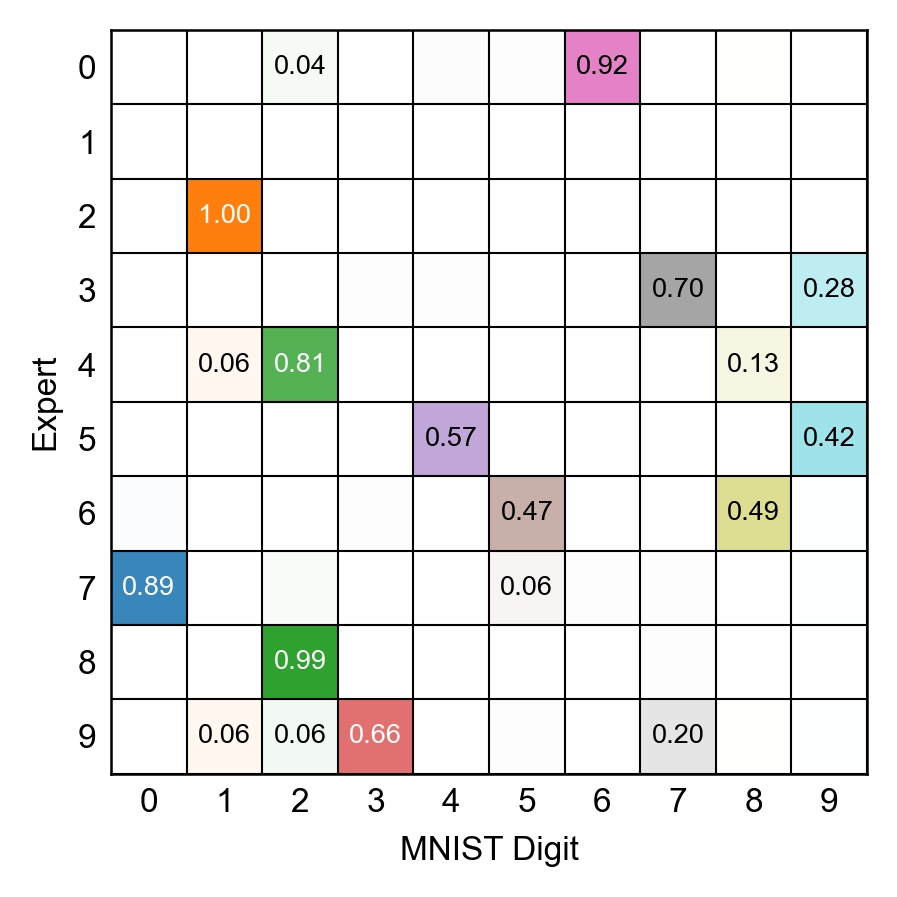

In [13]:
ax = draw_sparse_routing_heatmap(
    cm_normalized,
    column_colors=[colors[k] for k in dark_colors],
    row_labels=[str(i) for i in range(10)],
    col_labels=[str(i) for i in range(10)],
    #title="MNIST Synthetic: Expert Assignments vs. True Labels"
)
plt.tight_layout()
plt.savefig(os.path.join(synthetic_data_dir, f'expert_assignments_vs_true_labels_{model_id}.pdf'))
plt.show()

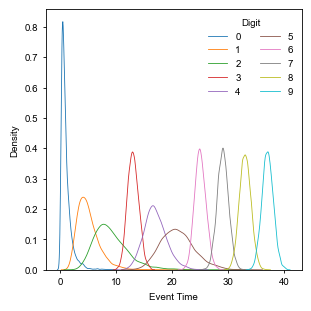

In [14]:
raw_event_times = train_model_outputs['t'][~train_model_outputs['c']]
train_labels = train_model_outputs['y'][~train_model_outputs['c']]
# density plot for each class
fig, ax = plt.subplots(figsize=(3, 3), layout='constrained')
classes = [i for i in range(10)]
for c in classes:
    class_mask = train_labels == c
    class_samples = raw_event_times[class_mask]
    sns.kdeplot(class_samples, ax=ax, label=f"{c}", color=colors[dark_colors[c]])
plt.xlabel("Event Time")
plt.ylabel("Density")
# put the legend outside the plot to the right, no border around the legend, smaller font size
# bbox_to_anchor=(1.05, 1), loc='upper left',
# put digits in two columns in the legend, no border around the legend, smaller font size
plt.legend(title='Digit', fontsize=7, frameon=False, ncol=2)
# plt.tight_layout()
plt.savefig(os.path.join(synthetic_data_dir, 'event_time_density_by_digit.pdf'))
plt.show()